<a href="https://colab.research.google.com/github/clashleyuncc/Intro-To-ML/blob/main/Final-Project/MLProjectFCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cuda
Target classes: ['Light_Load' 'Maximum_Load' 'Medium_Load']
155651
[7168, 512, 131072, 256, 16384, 64, 192, 3]
Esimated run time for 1000 Epoch: 9.587 minutes
0.57536 Seconds, Epoch 1, Training Loss 1.0185701847076416, Validation Loss 1.015499472618103
59.05735 Seconds, Epoch 100, Training Loss 0.44635528326034546, Validation Loss 0.3868095576763153
116.56521 Seconds, Epoch 200, Training Loss 0.34869271516799927, Validation Loss 0.3453918397426605
173.94344 Seconds, Epoch 300, Training Loss 0.38619908690452576, Validation Loss 0.3253594934940338
231.45985 Seconds, Epoch 400, Training Loss 0.29996457695961, Validation Loss 0.30509522557258606
290.20239 Seconds, Epoch 500, Training Loss 0.35620927810668945, Validation Loss 0.29558098316192627
346.99322 Seconds, Epoch 600, Training Loss 0.22013315558433533, Validation Loss 0.28953540325164795
404.32584 Seconds, Epoch 700, Training Loss 0.301729679107666, Validation Loss 0.28518179059028625
461.44757 Seconds, Epoch 800, 

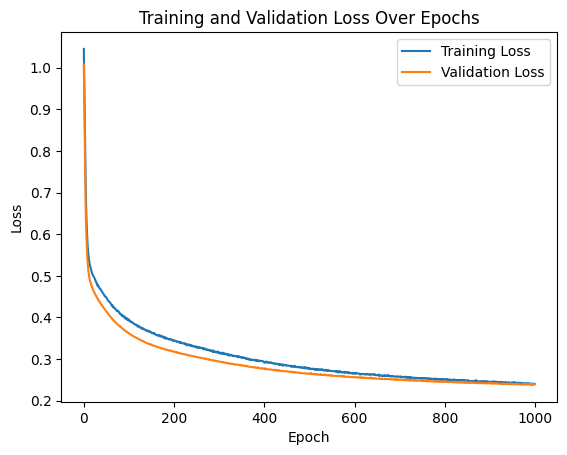

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3700
           1       0.79      0.84      0.81      1437
           2       0.82      0.78      0.80      1871

    accuracy                           0.89      7008
   macro avg       0.86      0.86      0.86      7008
weighted avg       0.89      0.89      0.89      7008



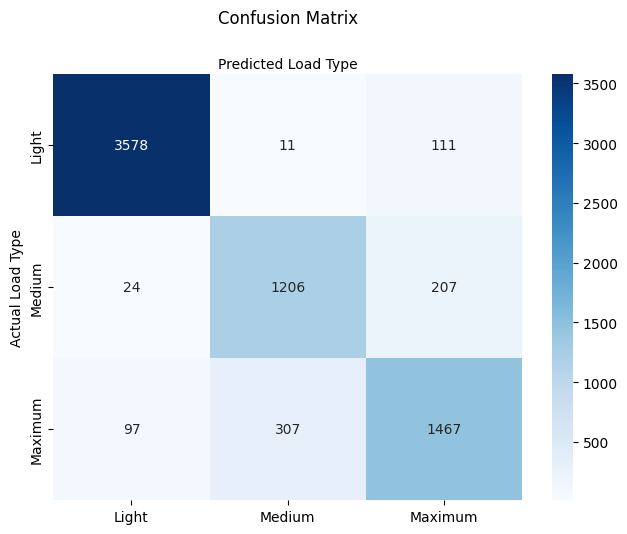

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from collections import OrderedDict
import time
from torch.utils.data import DataLoader, TensorDataset

# Check device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load and prepare the data (this part stays the same as your existing code)

!pip3 install -U ucimlrepo
from ucimlrepo import fetch_ucirepo

# Fetch dataset
steel_industry_energy_consumption = fetch_ucirepo(id=851)

y = steel_industry_energy_consumption.data.targets
X = steel_industry_energy_consumption.data.features

# Check for missing values and handle them
if X.isnull().sum().any():
    X = X.fillna(X.median())  # Replace missing values with median

# Encode categorical features if they exist
categorical_columns = ['WeekStatus', 'Day_of_week']
for col in categorical_columns:
    if col in X.columns:
        X = pd.get_dummies(X, columns=[col], drop_first=True, dtype='float')

# Identify and scale continuous features if they exist
continuous_columns = [
    'Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh',
    'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)',
    'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM'
]
existing_continuous_columns = [col for col in continuous_columns if col in X.columns]
scaler = StandardScaler()
X[existing_continuous_columns] = scaler.fit_transform(X[existing_continuous_columns])

# Ensure y is a Series if it's a single-column DataFrame
if isinstance(y, pd.DataFrame):
    y = y.iloc[:, 0]  # Extract the first column as a Series

# Encode target variable if categorical
if y.dtype == 'object' or isinstance(y.iloc[0], str):
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    print("Target classes:", label_encoder.classes_)

# Convert data to tensors and send to device
t_c = torch.tensor(y).to(device)
t_u = torch.tensor(X.to_numpy()).to(torch.float32).to(device)

# Split data into training and validation sets
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)
shuffled_indices = torch.randperm(n_samples)
train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]
t_u_train = t_u[train_indices].to(device)
t_c_train = t_c[train_indices].to(device)
t_u_val = t_u[val_indices].to(device)
t_c_val = t_c[val_indices].to(device)

# Create TensorDatasets for training and validation sets
train_dataset = TensorDataset(t_u_train, t_c_train)
val_dataset = TensorDataset(t_u_val, t_c_val)

# Create DataLoaders for both training and validation sets
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

train_losses = []
val_losses = []

train_losses2 = []
val_losses2 = []

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear1', nn.Linear(14, 512)),
    ('hidden_activation1', nn.LeakyReLU()),
    ('hidden_linear2', nn.Linear(512, 256)),
    ('hidden_activation2', nn.LeakyReLU()),
    ('hidden_linear3', nn.Linear(256, 64)),
    ('hidden_activation3', nn.LeakyReLU()),
    ('dropout', nn.Dropout(p=0.5)),
    ('output_linear', nn.Linear(64, 3))
]))

numel_list = [p.numel() for p in seq_model.parameters()]
print(sum(numel_list))
print(numel_list)

seq_model = seq_model.to(device)  # Send model to device

optimizer = optim.Adam(seq_model.parameters(), lr=1e-5)

def training_loop(n_epochs, optimizer, seq_model, loss_fn, train_loader, val_loader):
    for epoch in range(1, n_epochs + 1):
        seq_model.train()  # Set the model to training mode
        total_train_loss = 0  # To track the training loss
        for batch_idx, (t_u_batch, t_c_batch) in enumerate(train_loader):
            t_u_batch, t_c_batch = t_u_batch.to(device), t_c_batch.to(device)
            optimizer.zero_grad()
            t_p_batch = seq_model(t_u_batch)

            loss_train = loss_fn(t_p_batch, t_c_batch)
            total_train_loss += loss_train.item()

            loss_train.backward()
            optimizer.step()

        avg_train_loss = total_train_loss / len(train_loader)

        seq_model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for t_u_batch, t_c_batch in val_loader:
                t_u_batch, t_c_batch = t_u_batch.to(device), t_c_batch.to(device)

                t_p_batch = seq_model(t_u_batch)
                loss_val = loss_fn(t_p_batch, t_c_batch)
                total_val_loss += loss_val.item()

        avg_val_loss = total_val_loss / len(val_loader)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        if epoch == 1:
          print('Esimated run time for {} Epoch: {} minutes'.format(
                n_epochs, round((time.time()-start_time)*n_epochs/60,3)))
        if epoch == 1 or epoch % 100 == 0:
          print('{} Seconds, Epoch {}, Training Loss {}, Validation Loss {}'.format(
              round(time.time()-start_time,5), epoch, loss_train.item(), loss_val.item()))

start_time = time.time()

training_loop(
    n_epochs=1000,
    optimizer=optimizer,
    seq_model=seq_model,
    loss_fn=nn.CrossEntropyLoss(),
    train_loader=train_loader,
    val_loader=val_loader
)

# Plot training and validation loss
train_losses_cpu = torch.tensor(train_losses).cpu().numpy()
val_losses_cpu = torch.tensor(val_losses).cpu().numpy()

with torch.no_grad():
    plt.plot(train_losses_cpu, label="Training Loss")
    plt.plot(val_losses_cpu, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss Over Epochs")
    plt.show()

seq_model.eval()

with torch.no_grad():
    t_u_val = t_u_val.to(device)
    predictions = seq_model(t_u_val)
    predicted_classes = torch.argmax(predictions, dim=1)

t_c_val = t_c_val.cpu().numpy()
predicted_classes = predicted_classes.cpu().numpy()

# Confusion Matrix
matrix = confusion_matrix(t_c_val, predicted_classes)
report = classification_report(t_c_val, predicted_classes)
print(report)

# Plot Confusion Matrix
class_names = ['Light', 'Medium', 'Maximum']  # name of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# Create heatmap
sns.heatmap(pd.DataFrame(matrix), annot=True, cmap="Blues", fmt='g',#YlGnBu
            xticklabels=class_names, yticklabels=class_names)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion Matrix', y=1.1)
plt.ylabel('Actual Load Type')
plt.xlabel('Predicted Load Type')
plt.show()
